## Imports

In [ ]:
import pandas as pd
import os
from utility import compute_lsa_distance, find_scale_and_translation, calculate_jac
import numpy as np
from registration import friendly_names
from correction import apply_corrections

## Load the coordinate data file

In [ ]:

data_file = r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\coordinate_data_deidentified.csv'

data = pd.read_csv(data_file)
print(data.shape)
#data = data[data.csv_path.str.contains('nuclei', na=False)]
print(data.shape)


(108702, 7)
(108702, 7)


## Load the ground truth data

In [49]:
ground_truth_file = r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\ground_truth_coords.csv'

ground_truth = pd.read_csv(ground_truth_file)
print(ground_truth.shape)

# Display the first few rows of the ground truth data
ground_truth['base_name'] = ground_truth['path'].apply(os.path.basename)
ground_truth.head()

(6024, 5)


,Unnamed: 0,x,y,z,path,base_name
0,0,5.628644,9.198676,8.751923,../../ground truth/nuclei/out_c00_dr90_label.tif,out_c00_dr90_label.tif
1,1,22.816774,9.033185,6.689963,../../ground truth/nuclei/out_c00_dr90_label.tif,out_c00_dr90_label.tif
2,2,22.618367,26.020343,15.707744,../../ground truth/nuclei/out_c00_dr90_label.tif,out_c00_dr90_label.tif
3,3,13.676880,23.516335,14.263662,../../ground truth/nuclei/out_c00_dr90_label.tif,out_c00_dr90_label.tif
4,4,25.001824,8.219340,21.236781,../../ground truth/nuclei/out_c00_dr90_label.tif,out_c00_dr90_label.tif


## Open combined data

Open the file (combined data deidentified.csv) containing the meta data, survey data and the metrics calculated by ABRF

In [50]:

combined_data = pd.read_csv(r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\combined data deidentified.csv')
combined_data = combined_data[['responseid', 'qx.2','setName','lsa_mse_raw', 'lsa_mse_transformed']]

print(combined_data.shape)
# only keep rows where nuclei is in the setName
#combined_data = combined_data[combined_data.setName.str.contains('nuclei')]

print(combined_data.shape)
combined_data.head()

(159, 5)
(159, 5)


,responseid,qx.2,setName,lsa_mse_raw,lsa_mse_transformed
0,R_31bjqd6Mm8wBxN5,Python,nuclei1,182.451824,56.679462
1,R_31bjqd6Mm8wBxN5,Python,nuclei2,47.222279,21.174983
2,R_31bjqd6Mm8wBxN5,Python,nuclei3,105.577865,18.732895
3,R_31bjqd6Mm8wBxN5,Python,nuclei4,88.287150,19.067347
4,R_3lAJ9xY4kGlL99f,Python,nuclei1,565.205858,0.017590


In [ ]:

combined_data['lsa_mse_label_corrected'] = 0
combined_data['lsa_mse_label_and_image_corrected'] = 0
combined_data['lsa_mse_transformed'] = 0
combined_data['lsa_mse_best'] = 0
combined_data['correction'] = 'NONE'
combined_data['jac'] = 0
combined_data['jac_transformed'] = 0
combined_data['jac_best'] = 0

for index, row in combined_data.iterrows():

    responseid = row['responseid']
    print(f'Processing responseid: {responseid}')
    
    data_name = row['setName'].strip()
    test_data = data[data.csv_path.str.contains(responseid, na=False)]

    if test_data.shape[0] == 0:
        print(f'No test data found for responseid {responseid}')
        continue
    
    print('data name', data_name)
    unique_paths = test_data.csv_path.unique()

    key = next(k for k, v in friendly_names.items() if v == data_name)
    print(key)  # Output: 'out_c00_dr10_label.tif'

    data_to_find = test_data[test_data.csv_path.str.contains(data_name, na=False, case=False)]
    print(f'there are {data_to_find.shape[0]} rows for {data_name} in responseid {responseid}')

    if data_to_find.shape[0] == 0:
        print(f'No test data found for {data_name} in responseid {responseid}')
        continue
    print(f'there are {len(data_to_find.csv_path.unique())} unique test csv paths')

    gt = ground_truth[ground_truth['base_name'] == key]
    print(f'there are {gt.shape[0]} rows for {key}')

    name = data_to_find['csv_path'].iloc[0]
    td = data_to_find[data_to_find.csv_path == name]
    
    td = td[['x', 'y', 'z']].apply(pd.to_numeric, errors='coerce').fillna(0)

    # remove any zero rows from answer
    td = td[(td[['x', 'y', 'z']] != 0).any(axis=1)]

    a, b, lsa_mean = compute_lsa_distance(
        gt[['x', 'y', 'z']].values,
        td[['x', 'y', 'z']].fillna(0).values.astype(float)
    )
    print(f'lsa mean raw: {lsa_mean}')
   
    gt_corrected = gt.copy()   
    
    if 'nuclei' in data_name: 
        gt_corrected['z'] = gt['z']*(.124/.2)
    else:
        gt_corrected['z'] = gt['z']*(.1616160/.2)
    
    gt_corrected = gt_corrected[['x', 'y', 'z']].fillna(0).astype(float)
    
    a_, b_, lsa_mean_label_spacings_corrected = compute_lsa_distance(
        gt_corrected[['x', 'y', 'z']].values,
        td[['x', 'y', 'z']].fillna(0).values.astype(float)
    )

    print(f'lsa mean label spacings corrected: {lsa_mean_label_spacings_corrected}')
    
    td_corrected, correction = apply_corrections(td, responseid, data_name)

    combined_data.loc[(combined_data['responseid'] == responseid) &
                        (combined_data['setName'] == data_name), 
                        'correction'] = correction

    a, b, lsa_mean_corrected = compute_lsa_distance(
        gt_corrected.values,
        td_corrected.values
    )

    if 'fish' in data_name:
        tp, fp, fn, jac = calculate_jac(
            gt_corrected[['x', 'y', 'z']].values,
            td_corrected[['x', 'y', 'z']].values, lsa=(a,b)
        )
        print(f'jac is {jac}, tp: {tp}, fp: {fp}, fn: {fn}')
    else:
        jac, tp, fp, fn = 0, 0, 0, 0 

    #if 'R_2rCMx6wAGE7bFJh' in responseid and 'nuclei' in data_name: 
    scale, translation = find_scale_and_translation(gt_corrected, td_corrected, True)
    print(f'detected scale: {scale}, detected translation: {translation}')

    td_transformed = td_corrected.copy()

    td_transformed['x']= td_corrected['x']*scale[0,0] + translation[0,0]
    td_transformed['y']= td_corrected['y']*scale[0,1] + translation[0,1]
    td_transformed['z']= td_corrected['z']*scale[0,2] + translation[0,2]

    scale, translation = find_scale_and_translation(gt_corrected, td_corrected)
    print(f'detected scale: {scale}, detected translation: {translation}')
    #correction = "AUTOMATIC"

    a, b, lsa_mean_corrected_transformed = compute_lsa_distance(
        gt_corrected.values,
        td_transformed.values
    )

    if 'fish' in data_name:
        tp, fp, fn, jac_transformed = calculate_jac(
            gt_corrected[['x', 'y', 'z']].values,
            td_transformed[['x', 'y', 'z']].values, lsa=(a,b)
        )
        print(f'jac transformed is {jac_transformed}, tp: {tp}, fp: {fp}, fn: {fn}')
    else:
        jac_transformed, tp, fp, fn = 0, 0, 0, 0 
          
    print(f'lsa mse raw: {lsa_mean}')
    print(f'lsa mse transformed: {lsa_mean_corrected}')
    print(f'jac: {jac}')
    print('=======================================================')

    # update the combined_data DataFrame with the computed values
    combined_data.loc[(combined_data['responseid'] == responseid) & 
                        (combined_data['setName'] == data_name), 
                        'lsa_mse_label_corrected'] = lsa_mean_label_spacings_corrected
    
    combined_data.loc[(combined_data['responseid'] == responseid) & 
                        (combined_data['setName'] == data_name), 
                        'lsa_mse_label_and_image_corrected'] = lsa_mean_corrected
    
    # best is min of lsa_mse_transformed and lsa_mse_transformed_alt
    combined_data.loc[(combined_data['responseid'] == responseid) & 
                        (combined_data['setName'] == data_name), 
                        'best'] =  combined_data[['lsa_mse_transformed', 'lsa_mse_label_and_image_corrected']].min(axis=1)
    
    combined_data.loc[(combined_data['responseid'] == responseid) &
                        (combined_data['setName'] == data_name), 
                        'jac'] = jac
    
    combined_data.loc[(combined_data['responseid'] == responseid) &
                        (combined_data['setName'] == data_name), 
                        'jac_transformed'] = jac_transformed
    
    combined_data.loc[(combined_data['responseid'] == responseid) &
                        (combined_data['setName'] == data_name), 
                        'lsa_mse_transformed'] = lsa_mean_corrected_transformed

    combined_data.loc[(combined_data['responseid'] == responseid) &
                        (combined_data['setName'] == data_name), 
                        'lsa_mse_best'] = min(lsa_mean_corrected, lsa_mean_corrected_transformed)
    
    combined_data.loc[(combined_data['responseid'] == responseid) &
                        (combined_data['setName'] == data_name), 
                        'jac_best'] = max(jac, jac_transformed)
    

Processing responseid: R_31bjqd6Mm8wBxN5
data name nuclei1
out_c00_dr90_label.tif
there are 5 rows for nuclei1 in responseid R_31bjqd6Mm8wBxN5
there are 1 unique test csv paths
there are 5 rows for out_c00_dr90_label.tif
lsa mean raw: 182.45182410519618
lsa mean label spacings corrected: 105.70139484092722
detected scale: [[1.00323818 1.00323818 1.00520221]], detected translation: [[-0.03374655  0.02866844 -0.02458869]]
detected scale: [[1.00323818 1.00323818 1.00520221]], detected translation: [[-0.03374655  0.02866844 -0.02458869]]
num_good: 1, num_bad: 0
lsa mse raw: 182.45182410519618
lsa mse transformed: 0.019770487446740256
jac: 0
Processing responseid: R_31bjqd6Mm8wBxN5


C:\Users\bnort\AppData\Local\Temp\ipykernel_35824\704609618.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '105.70139484092722' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_data.loc[(combined_data['responseid'] == responseid) &
C:\Users\bnort\AppData\Local\Temp\ipykernel_35824\704609618.py:150: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.019770487446740256' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_data.loc[(combined_data['responseid'] == responseid) &
C:\Users\bnort\AppData\Local\Temp\ipykernel_35824\704609618.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.011610509627968115' has dtype incompatible with int64, plea

data name nuclei2
out_c90_dr90_label.tif
there are 5 rows for nuclei2 in responseid R_31bjqd6Mm8wBxN5
there are 1 unique test csv paths
there are 5 rows for out_c90_dr90_label.tif
lsa mean raw: 47.222278976484276
lsa mean label spacings corrected: 22.69394231922051
detected scale: [[0.99912468 0.99912468 1.02446098]], detected translation: [[ 0.01556097  0.02794257 -0.14440509]]
detected scale: [[0.99912468 0.99912468 1.02446098]], detected translation: [[ 0.01556097  0.02794257 -0.14440509]]
num_good: 2, num_bad: 0
lsa mse raw: 47.222278976484276
lsa mse transformed: 0.019032444200394544
jac: 0
Processing responseid: R_31bjqd6Mm8wBxN5
data name nuclei3
out_c00_dr10_label.tif
there are 5 rows for nuclei3 in responseid R_31bjqd6Mm8wBxN5
there are 1 unique test csv paths
there are 5 rows for out_c00_dr10_label.tif
lsa mean raw: 105.57786460635778
lsa mean label spacings corrected: 72.88020901040093
detected scale: [[1.00165399 1.00165399 1.0250787 ]], detected translation: [[-0.15741128 

C:\Users\bnort\AppData\Local\Temp\ipykernel_35824\704609618.py:159: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.927381745502998' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_data.loc[(combined_data['responseid'] == responseid) &
C:\Users\bnort\AppData\Local\Temp\ipykernel_35824\704609618.py:163: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9280479680213192' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_data.loc[(combined_data['responseid'] == responseid) &
C:\Users\bnort\AppData\Local\Temp\ipykernel_35824\704609618.py:175: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9280479680213192' has dtype incompatible with int64, please ex

lsa mean raw: 647.8575953295809
lsa mean label spacings corrected: 647.9298010624805
jac is 0.7921385742838108, tp: 1189, fp: 216, fn: 96
detected scale: [[0.99313043 0.99313043 0.97635834]], detected translation: [[-0.06667499  0.29991406  0.01797729]]
detected scale: [[0.99313043 0.99313043 0.97635834]], detected translation: [[-0.06667499  0.29991406  0.01797729]]
jac transformed is 0.41305796135909395, tp: 620, fp: 785, fn: 96
num_good: 9, num_bad: 1
lsa mse raw: 647.8575953295809
lsa mse transformed: 2.084009008888506
jac: 0.7921385742838108
Processing responseid: R_3lAJ9xY4kGlL99f
data name fish3
celegans_dyn-10_ceff-0_label.ics.ome.tiff
there are 1759 rows for fish3 in responseid R_3lAJ9xY4kGlL99f
there are 1 unique test csv paths
there are 1501 rows for celegans_dyn-10_ceff-0_label.ics.ome.tiff
lsa mean raw: 394.31577246053433
lsa mean label spacings corrected: 393.78661032167753
jac is 0.8220579874928937, tp: 1446, fp: 313, fn: 0
detected scale: [[0.99956399 0.99956399 0.99632

c:\Users\bnort\miniconda3\envs\stardist_napari_windows\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bnort\miniconda3\envs\stardist_napari_windows\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\bnort\miniconda3\envs\stardist_napari_windows\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bnort\miniconda3\envs\stardist_napari_windows\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\bnort\miniconda3\envs\stardist_napari_windows\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bnort\miniconda3\e

data name nuclei1
out_c00_dr90_label.tif
there are 5 rows for nuclei1 in responseid R_1qdHCwPCdNvs9xi
there are 1 unique test csv paths
there are 5 rows for out_c00_dr90_label.tif
lsa mean raw: 28.991577715829813
lsa mean label spacings corrected: 0.019527803765608143
detected scale: [[1.00097126 1.00097126 0.99363157]], detected translation: [[-0.04036507 -0.05291216  0.00567054]]
detected scale: [[1.00097126 1.00097126 0.99363157]], detected translation: [[-0.04036507 -0.05291216  0.00567054]]
num_good: 51, num_bad: 9
lsa mse raw: 28.991577715829813
lsa mse transformed: 0.019527803765608143
jac: 0
Processing responseid: R_1qdHCwPCdNvs9xi
data name nuclei2
out_c90_dr90_label.tif
there are 5 rows for nuclei2 in responseid R_1qdHCwPCdNvs9xi
there are 1 unique test csv paths
there are 5 rows for out_c90_dr90_label.tif
lsa mean raw: 24.269178011191197
lsa mean label spacings corrected: 0.22604460162228707
detected scale: [[1.03332532 1.03332532 1.11213569]], detected translation: [[-0.351

In [32]:
combined_data.to_csv(r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\combined_data_deidentified_with_lsa_mse_transformed_alt8.csv', index=False)
combined_data.head()

,responseid,qx.2,setName,lsa_mse_raw,lsa_mse_transformed,lsa_mse_label_corrected,lsa_mse_label_and_image_corrected,best,correction,jac
0,R_31bjqd6Mm8wBxN5,Python,nuclei1,182.451824,56.679462,105.701395,0.019770,0.019770,REVERSE_XY,0.0
1,R_31bjqd6Mm8wBxN5,Python,nuclei2,47.222279,21.174983,22.693942,0.019032,0.019032,REVERSE_XY,0.0
2,R_31bjqd6Mm8wBxN5,Python,nuclei3,105.577865,18.732895,72.880209,0.066909,0.066909,REVERSE_XY,0.0
3,R_31bjqd6Mm8wBxN5,Python,nuclei4,88.287150,19.067347,44.821824,0.020630,0.020630,REVERSE_XY,0.0
4,R_3lAJ9xY4kGlL99f,Python,nuclei1,565.205858,0.017590,457.890494,0.070754,0.017590,REVERSE_XY_SCALE4,0.0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.__config__ import show

C:\Users\bnort\AppData\Local\Temp\ipykernel_35824\14511212.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['qx.2'] = df4["qx.2"].str.replace(' ', '\n')
C:\Users\bnort\AppData\Local\Temp\ipykernel_35824\14511212.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['qx.2'] = df4["qx.2"].str.replace(',', '\n')


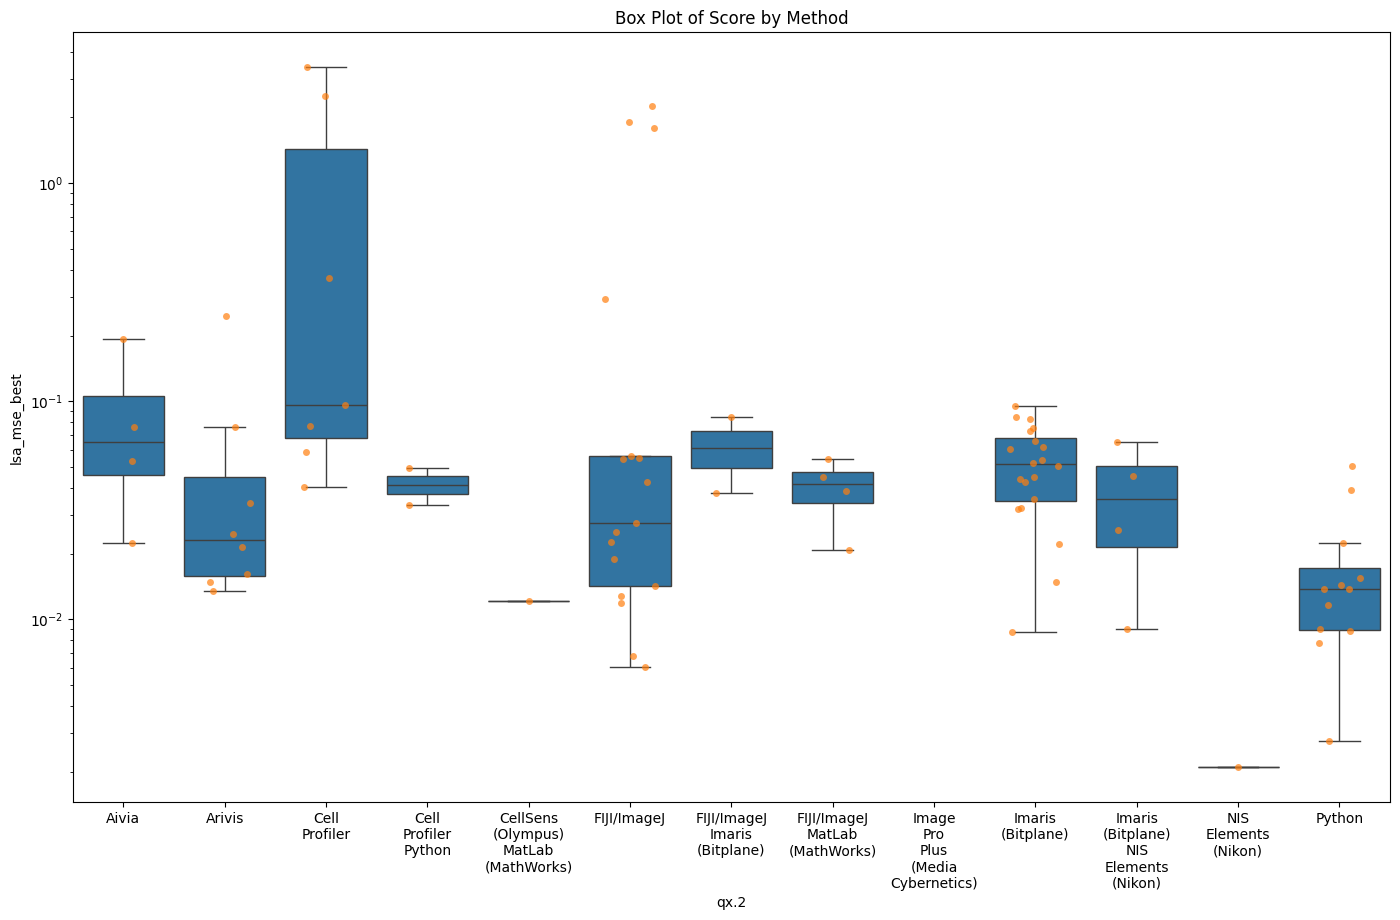

In [53]:
plt.figure(figsize=(17, 10))

statistic = 'lsa_mse_label_corrected'
statistic = 'lsa_mse_best'
df4= combined_data[combined_data.setName.str.contains('nuclei', na=False)]
df4['qx.2'] = df4["qx.2"].str.replace(' ', '\n')
df4['qx.2'] = df4["qx.2"].str.replace(',', '\n')
ordered_methods = sorted(df4['qx.2'].unique())
sns.boxplot(x='qx.2', y=statistic, data=df4.dropna(),showfliers=False, order=ordered_methods)
sns.stripplot(x='qx.2', y=statistic, data=df4.dropna(), jitter=0.25, alpha=0.7)
plt.yscale('log')
plt.title('Box Plot of Score by Method')
plt.show()

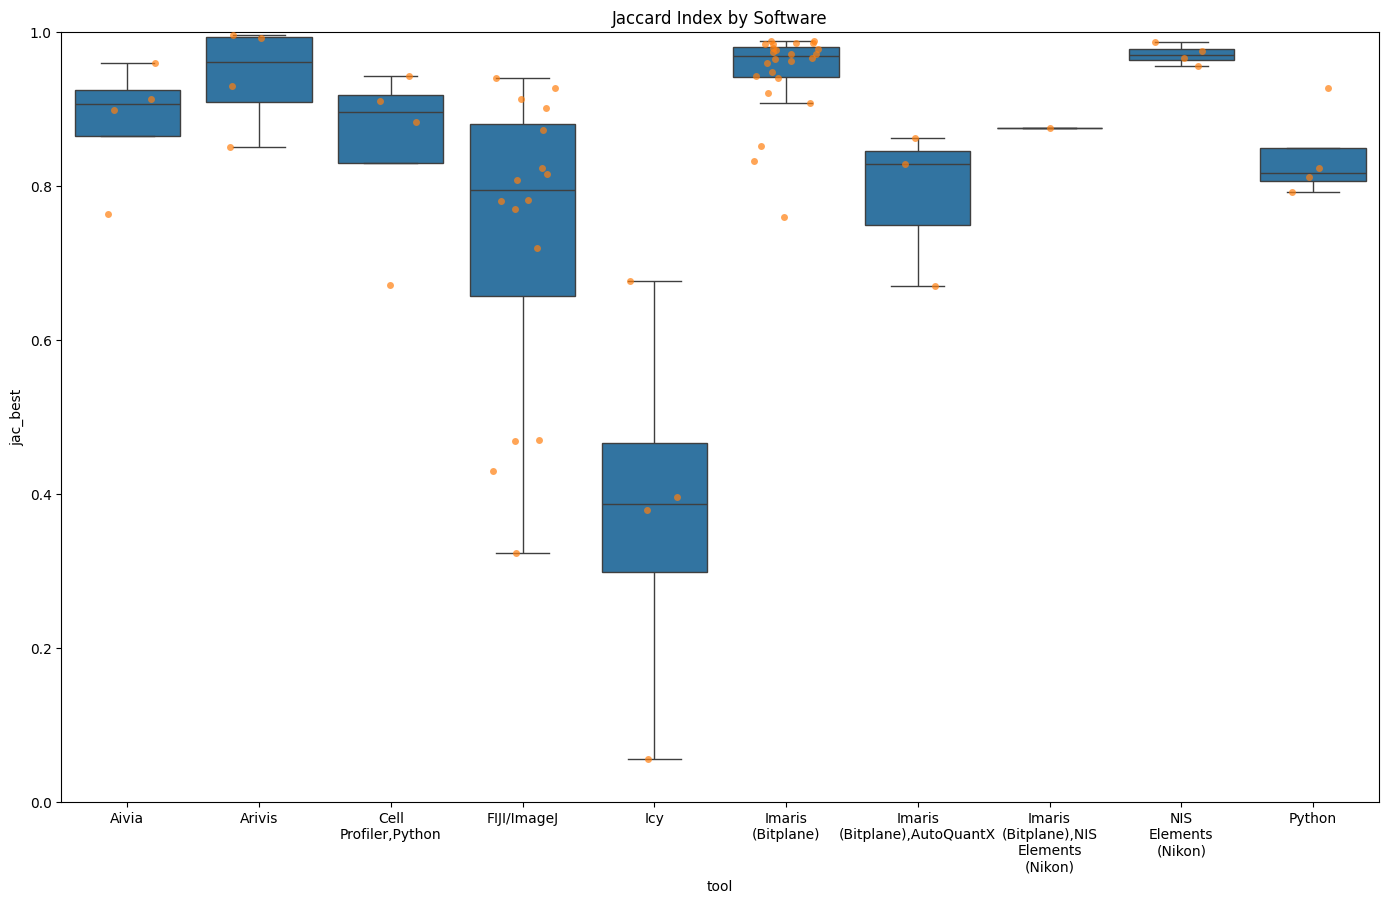

In [52]:
# Fish only
dffish = combined_data[combined_data['setName'].str.contains('fish', na=False)]
dffish = dffish[dffish['jac'] > 0]  # Filter out rows with jac <= 0

import matplotlib.pyplot as plt
def plot_softwares_jac(df, col_name, title):
    plt.figure(figsize=(17, 10))
    df['tool'] = df["qx.2"].str.replace(' ', '\n')
    ordered_methods = sorted(df['tool'].unique())
    sns.boxplot(x='tool', y=col_name, data=df, showfliers=False, order=ordered_methods)
    sns.stripplot(x='tool', y=col_name, data=df, jitter=0.25, alpha=0.7)
    plt.ylim(0, 1)   
    plt.title(title)
    plt.savefig(os.path.join(r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels', title), dpi=300)
    plt.show()
    
plot_softwares_jac(dffish, 'jac_best', 'Jaccard Index by Software')

In [60]:
df3[df3['qx.2']=='Cell Profiler,Python']

,responseid,qx.2,setName,lsa_mse_raw,lsa_mse_transformed,lsa_mse_label_corrected,lsa_mse_label_and_image_corrected,best,correction,jac
123,R_0638fJAPpmzLtu1,"Cell Profiler,Python",nuclei1,33946.444950,114.068490,0.000000,0.000000,0.000000,NONE,0.000000
124,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",nuclei1,28.194606,0.397946,0.000000,0.000000,0.000000,NONE,0.000000
125,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",nuclei2,NaN,NaN,0.000000,0.000000,0.000000,NONE,0.000000
126,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",nuclei3,NaN,NaN,0.000000,0.000000,0.000000,NONE,0.000000
127,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",nuclei4,NaN,NaN,0.000000,0.000000,0.000000,NONE,0.000000
128,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",fish1,0.962879,5.676291,1.720038,1.720038,1.720038,NONE,0.976173
129,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",fish2,NaN,NaN,8.438301,8.438301,8.438301,NONE,0.790698
130,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",fish3,NaN,NaN,1.722837,1.722837,1.722837,NONE,0.952315
131,R_6E6PxT3N1gr93yh,"Cell Profiler,Python",fish4,NaN,NaN,2.822022,2.822022,2.822022,NONE,0.929598
